In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

### Prepare data

In [2]:
# List of dataset to use for training
train_files = ["ssp126", "ssp585", "historical", "hist-GHG"]

In [3]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_tas = create_predictdand_data(train_files)['diurnal_temperature_range'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
tas_truth = Y_test["diurnal_temperature_range"].mean('member')

In [4]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_dtr = y_train_dtr[~nan_train_mask]
assert len(X_train) == len(y_train_dtr)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
dtr_truth = dtr_truth[~nan_test_mask]

In [5]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [6]:
# Standardize predictand fields
train_dtr_mean, train_dtr_std = y_train_dtr.mean(), y_train_dtr.std()
y_train_dtr = (y_train_dtr - train_dtr_mean) / train_dtr_std

### Prepare model

In [7]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

2022-04-01 15:28:45.376300: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-01 15:28:45.376333: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-01 15:28:45.376366: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (romeo): /proc/driver/nvidia/version does not exist
2022-04-01 15:28:45.376676: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_dtr.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [9]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

2022-04-01 15:28:45.436853: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.73528D+06    |proj g|=  9.84754D+05


 This problem is unconstrained.



At iterate    1    f=  3.24974D+06    |proj g|=  7.42415D+05

At iterate    2    f=  2.44494D+06    |proj g|=  4.71642D+05

At iterate    3    f=  2.07856D+06    |proj g|=  2.32835D+05

At iterate    4    f=  1.29502D+06    |proj g|=  4.57386D+05

At iterate    5    f=  1.18531D+06    |proj g|=  3.92213D+04

At iterate    6    f=  1.15969D+06    |proj g|=  8.92826D+04

At iterate    7    f=  1.12180D+06    |proj g|=  2.75455D+04

At iterate    8    f=  1.09718D+06    |proj g|=  1.71128D+04

At iterate    9    f=  1.08169D+06    |proj g|=  8.61571D+03

At iterate   10    f=  1.07524D+06    |proj g|=  5.92517D+03

At iterate   11    f=  1.06997D+06    |proj g|=  9.97939D+03

At iterate   12    f=  1.05839D+06    |proj g|=  4.11715D+03

At iterate   13    f=  1.05670D+06    |proj g|=  6.65259D+03

At iterate   14    f=  1.05544D+06    |proj g|=  4.91288D+03

At iterate   15    f=  1.05342D+06    |proj g|=  4.96865D+03

At iterate   16    f=  1.05222D+06    |proj g|=  5.04597D+04

At iter

      fun: 1037010.7955950277
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.10863186,  1.11723595, -2.9746954 ,  4.72370912, -0.10228435,
       -1.24898141, -4.01436508,  0.06004632,  2.72662288, -6.10215678,
       -2.43458771, -1.22530398,  2.38721641,  1.34330433, -2.81326864,
        0.74703136, -7.02638347, -1.43310484])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 303
      nit: 256
     njev: 303
   status: 0
  success: True
        x: array([ 7.8349432 ,  1.14044089,  1.13421647, -3.52561548, -2.94928086,
       -1.70142153, -2.22169287, 12.37528867,  7.61959472, -4.13563411,
        6.2761269 , 21.36296984, 47.35423232, 27.7936148 , 51.25049996,
       -3.20301657, -2.62716779, -0.07221347])


At iterate  256    f=  1.03701D+06    |proj g|=  7.02638D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18    256    303      1     0     0   7.026D+00   1.037D+06
  F =   1037010.7955950277     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


### Predict on testing set

In [10]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_dtr_std + train_dtr_mean
posterior_std = np.sqrt(standard_posterior_var) * train_dtr_std

In [11]:
# put output back into xarray format for calculating RMSE/plotting
posterior_dtr = np.reshape(posterior_mean, [86, 96, 144])
posterior_dtr_std = np.reshape(posterior_std, [86, 96, 144])

posterior_dtr_data = xr.DataArray(posterior_dtr, dims=dtr_truth.dims, coords=dtr_truth.coords)
posterior_dtr_std_data = xr.DataArray(posterior_dtr_std, dims=dtr_truth.dims, coords=dtr_truth.coords)

In [12]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(dtr_truth[35], posterior_dtr_data[35])}")
print(f"RMSE at 2100: {get_rmse(dtr_truth[85], posterior_dtr_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(dtr_truth[30:41], posterior_dtr_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(dtr_truth[75:], posterior_dtr_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(dtr_truth[35:], posterior_dtr_data[35:]).mean()}")

RMSE at 2050: 0.13362586191010017
RMSE at 2100: 0.14599638637840393
RMSE 2045-2055: 0.13909134520465447
RMSE 2090-2100: 0.16175696020781863
RMSE 2050-2100: 0.1540866257718039


[Text(0.5, 1.0, 'Difference')]

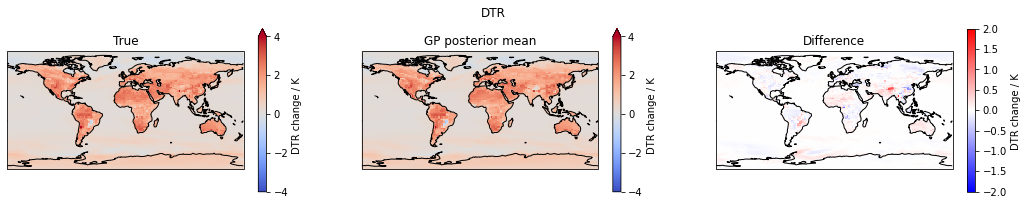

In [13]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## DTR
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('DTR')

# Test
plt.subplot(131, projection=proj)
dtr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-4,
                              cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_dtr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-4,
                              cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = dtr_truth - posterior_dtr_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

__Feature importance__
- Really just CO2 (1.54) 

In [14]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[-0.07221347]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.4178286917729193
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,7.835338789204252
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.02900883160769163
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.4131156331953179
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.015865987821265654
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.05105176, 0.16756658, 0.10294045..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.03983535791620495
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[6.2780058, 21.36296984, 47.35423232..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.06979092026929104


In [16]:
# Save predictions
posterior_dtr_data.to_netcdf('climatebench-gp-posterior-mean-dtr-test-2019-2100.nc')
posterior_dtr_std_data.to_netcdf('climatebench-gp-posterior-std-dtr-test-2019-2100.nc')